In [6]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [11]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

mps


# param setting

In [148]:
EPOCHS = 500
LR = 1e-3
BS = 16
SEED = 42
WINDOW_SIZE = 7
KERNEL_SIZE = 5
STRIDE = 1
MODEL_NAME ='conv2d_model_type'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [149]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

In [112]:
train_df

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


# Data scaling

In [150]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

In [151]:
def making_model_input(x):
    s_size = WINDOW_SIZE
    x = np.array(x)
    data = []
    cnt = x.shape[0]-s_size+1
    for i in range(0,cnt,STRIDE):
        tmp = x[i:i+s_size][:]
        #tmp = tmp - np.mean(tmp,axis=0)
        data.append(tmp.reshape(1,WINDOW_SIZE, WINDOW_SIZE))
    return np.array(data)

In [152]:
def making_2d(x):
    s_Size = WINDOW_SIZE
    x = np.array(x)
    data = []
    for i in range(x.shape[0]):
        data.append(x[i][0][:])
    for i in range(x.shape[1]-1):
        data.append(x[x.shape[0]-1][i][:])
    result = np.array(data)
    return(result)


# Make custom dataset

In [153]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

# Autoencoder model using fully connect layer, dropout, batchnorm1d, he_normal

In [155]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=4, kernel_size=KERNEL_SIZE, stride=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=KERNEL_SIZE, stride=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
        )
        self.Decoder = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=KERNEL_SIZE,stride=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            nn.Conv2d(in_channels=4, out_channels=1, kernel_size=KERNEL_SIZE,stride=1),
        )
        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        #print(encoded.shape)
        decoded = self.Decoder(encoded)
        #print(decoded.shape)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
  

In [156]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, index):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, true, pred= self.validation(self.model)
            
            #true_2d = making_2d(true)
            #pred_2d = making_2d(pred)
            #error = true_2d - pred_2d
            #mse = np.mean(np.power(error,2),axis=1)
            
            mean_train_loss = np.mean(train_loss)
            
            #print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+str(index)+'.pth')
                #print("Save Model~_~")
        
        print(best_loss)
        return best_loss * 5
    
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        true = []
        pred = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                #print(mse.shape)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                true += x.detach().tolist()
                pred += _x.detach().tolist()
        
        return np.mean(val_loss), true, pred

# fit

In [157]:
scaler_list = []
mean_loss_list = []
for i in range(8):
    train_data = train_each_list[i]
    train_data = train_data.loc[train_data['motor_vibe'] < 10]
    train_data_drop = train_data.drop('type', axis=1)
    train_x, val_x = train_test_split(train_data_drop, test_size = 0.1, random_state=SEED, shuffle=False)
    
    print(i)
    scaler = StandardScaler()
    train_x = scaler.fit_transform(np.array(train_x))
    val_x = scaler.transform(np.array(val_x))
    scaler_list.append(scaler)
    
    train_dataset = MyDataset(making_model_input(train_x))
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
    val_dataset = MyDataset(making_model_input(val_x))
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
    
    it = iter(train_loader)
    in_features = next(it)[0].shape[0]
    
    
    gc.collect()

    seed_everything(SEED) # Seed 고정 (모델 생성전에 다시 고정하였더니 재현이 똑같이됨..
    model = AutoEncoder(in_features)
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR,weight_decay=1e-1)#Opimizer : AdamW
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
    trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
    #trainer 객체 생성
    mean_loss_list.append(trainer.fit(i))

0
Epoch 00298: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00353: reducing learning rate of group 0 to 2.5000e-04.
0.00014221056820436692
1
Epoch 00308: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00336: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00414: reducing learning rate of group 0 to 1.2500e-04.
0.0006155076262075454
2
Epoch 00398: reducing learning rate of group 0 to 5.0000e-04.
0.0005747586546931416
3
Epoch 00169: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00443: reducing learning rate of group 0 to 2.5000e-04.
0.0010480776836629957
4
0.0006633696320932359
5
Epoch 00222: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00259: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00377: reducing learning rate of group 0 to 1.2500e-04.
0.00139747402863577
6
Epoch 00379: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00400: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00421: reducing learning rate of group 0 to

In [21]:
pretrained_model = torch.load('./' + MODEL_NAME+'/.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

FileNotFoundError: [Errno 2] No such file or directory: './conv1d_model_type/.pth'

(1296, 7)
0


/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


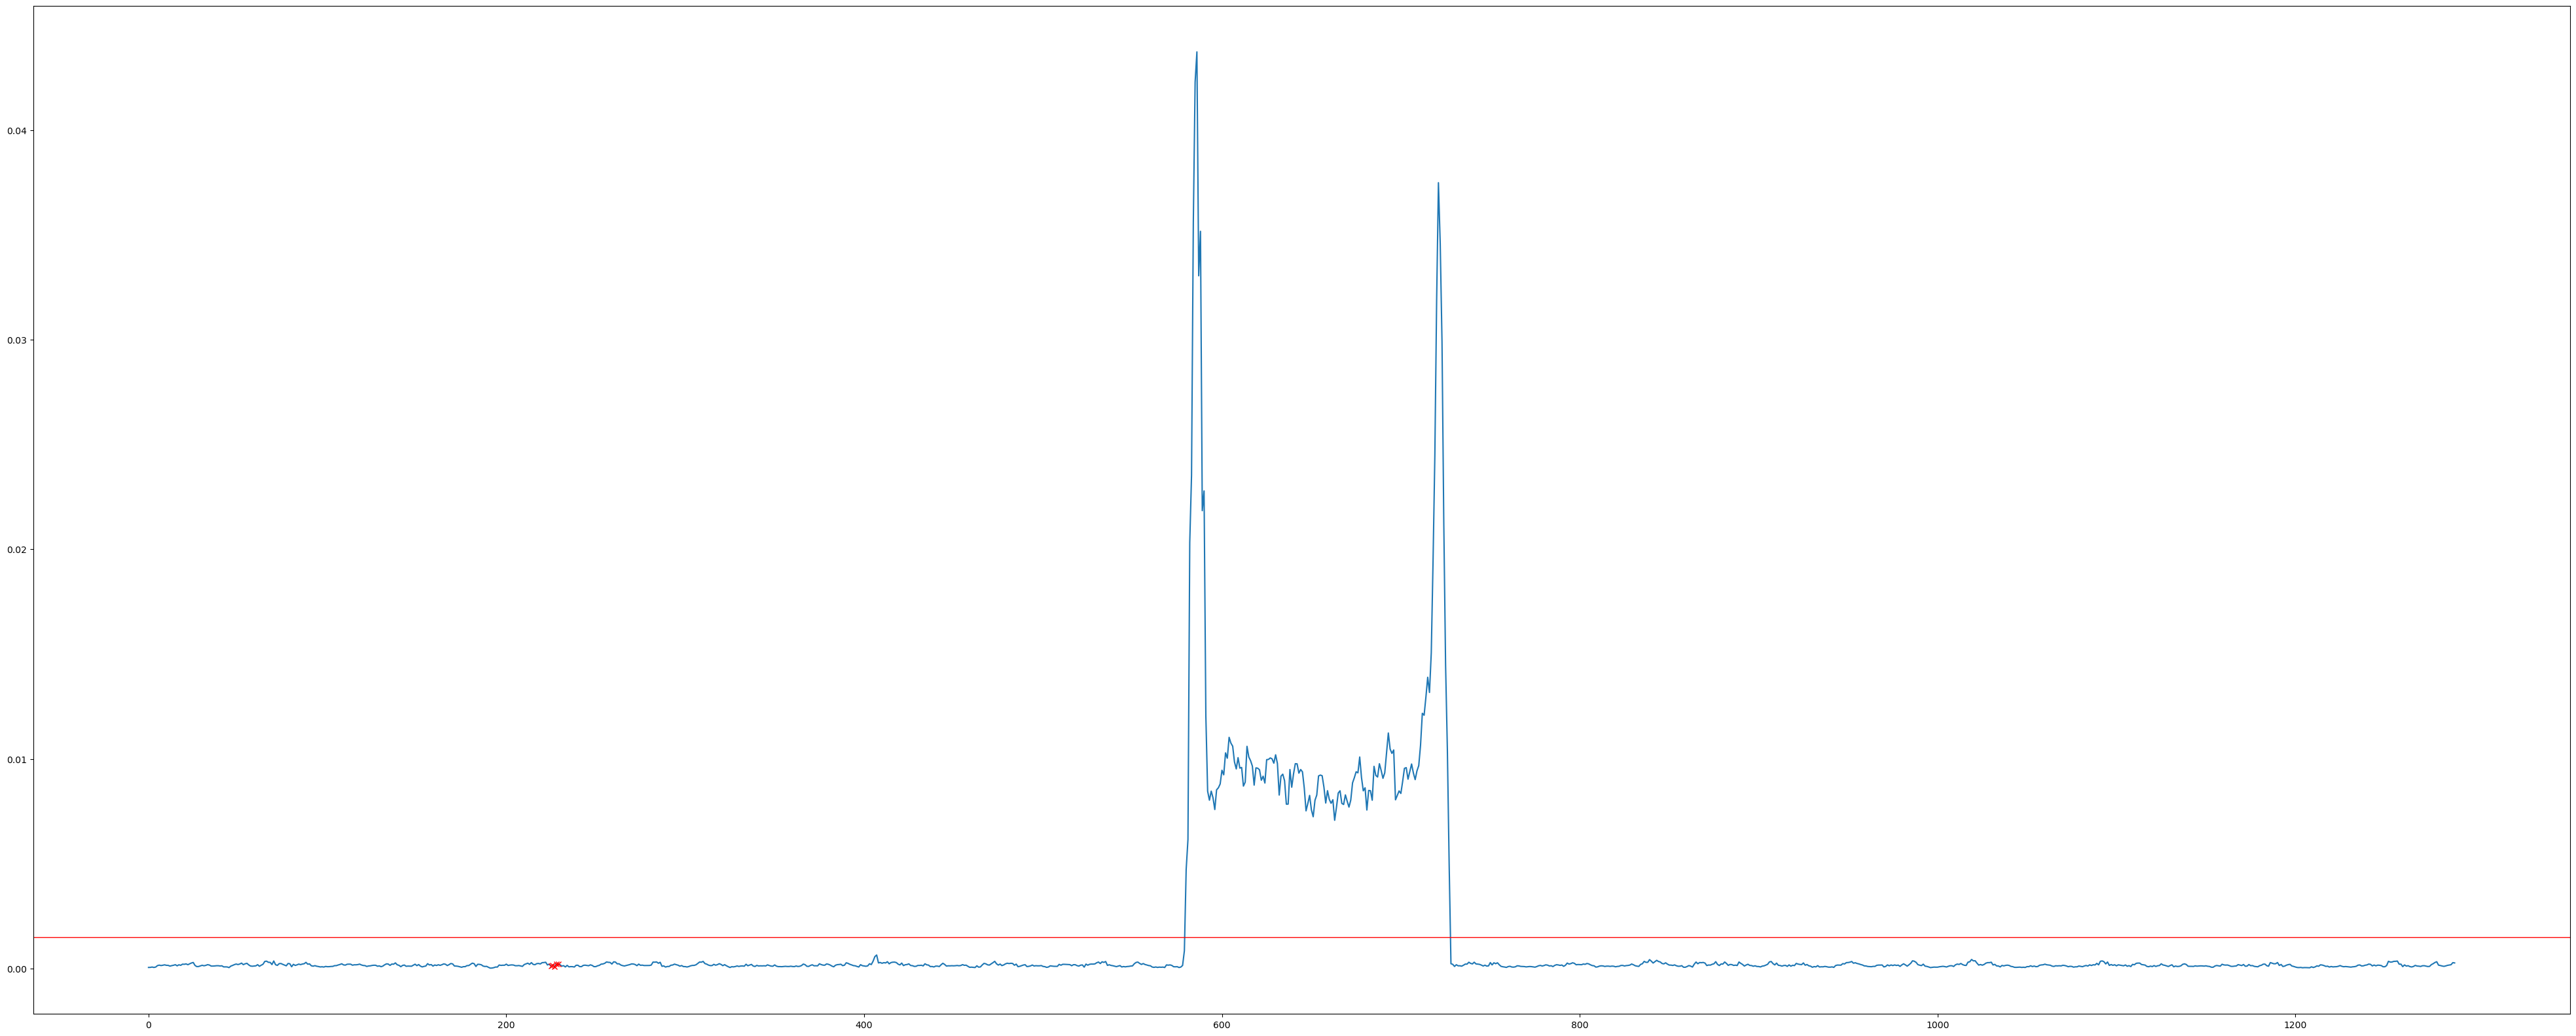

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1107, 7)
1


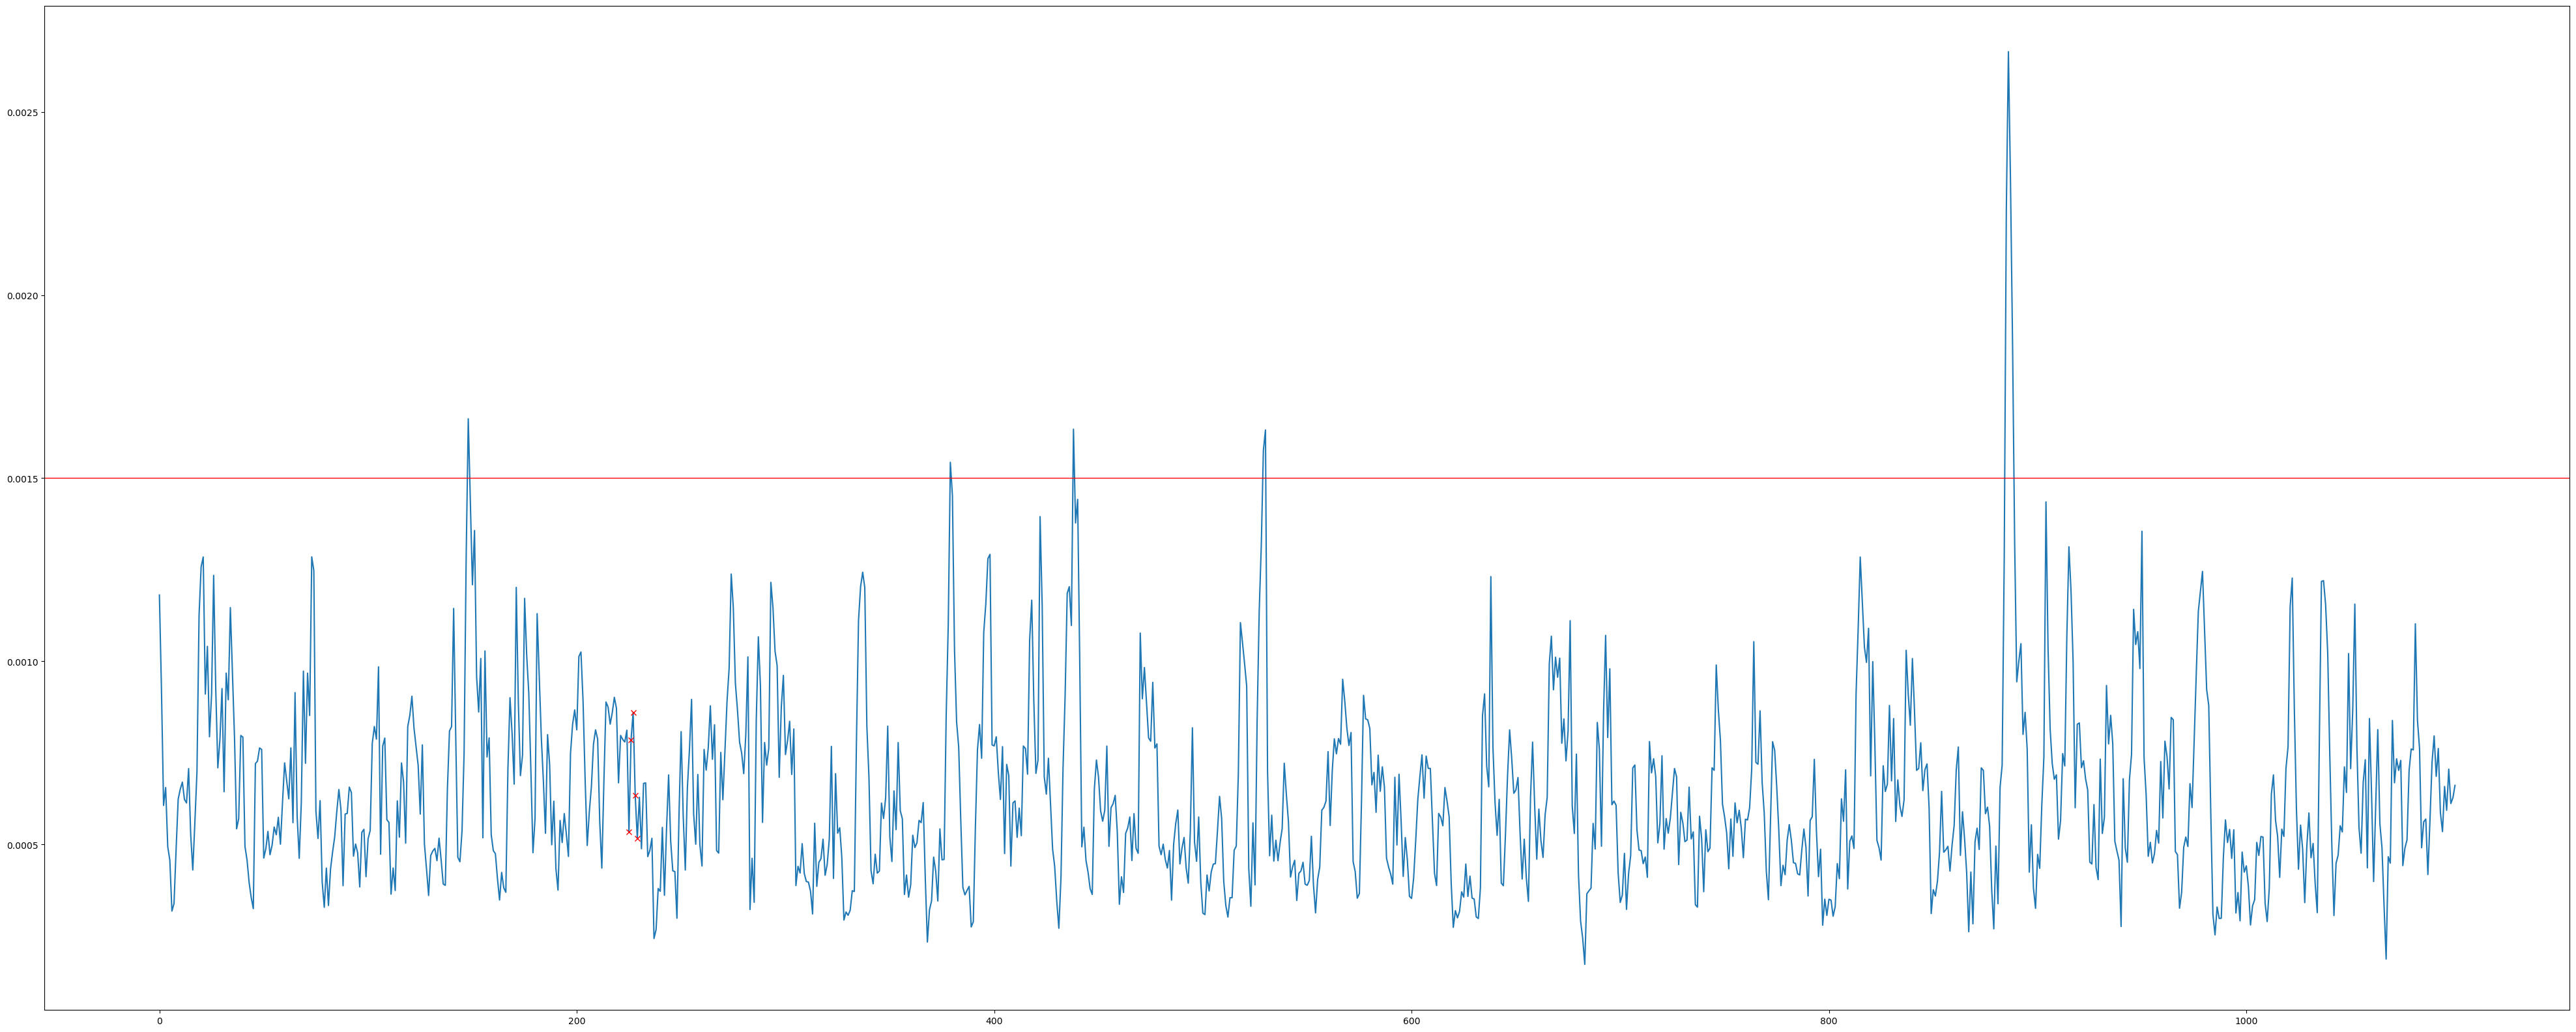

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1098, 7)
2


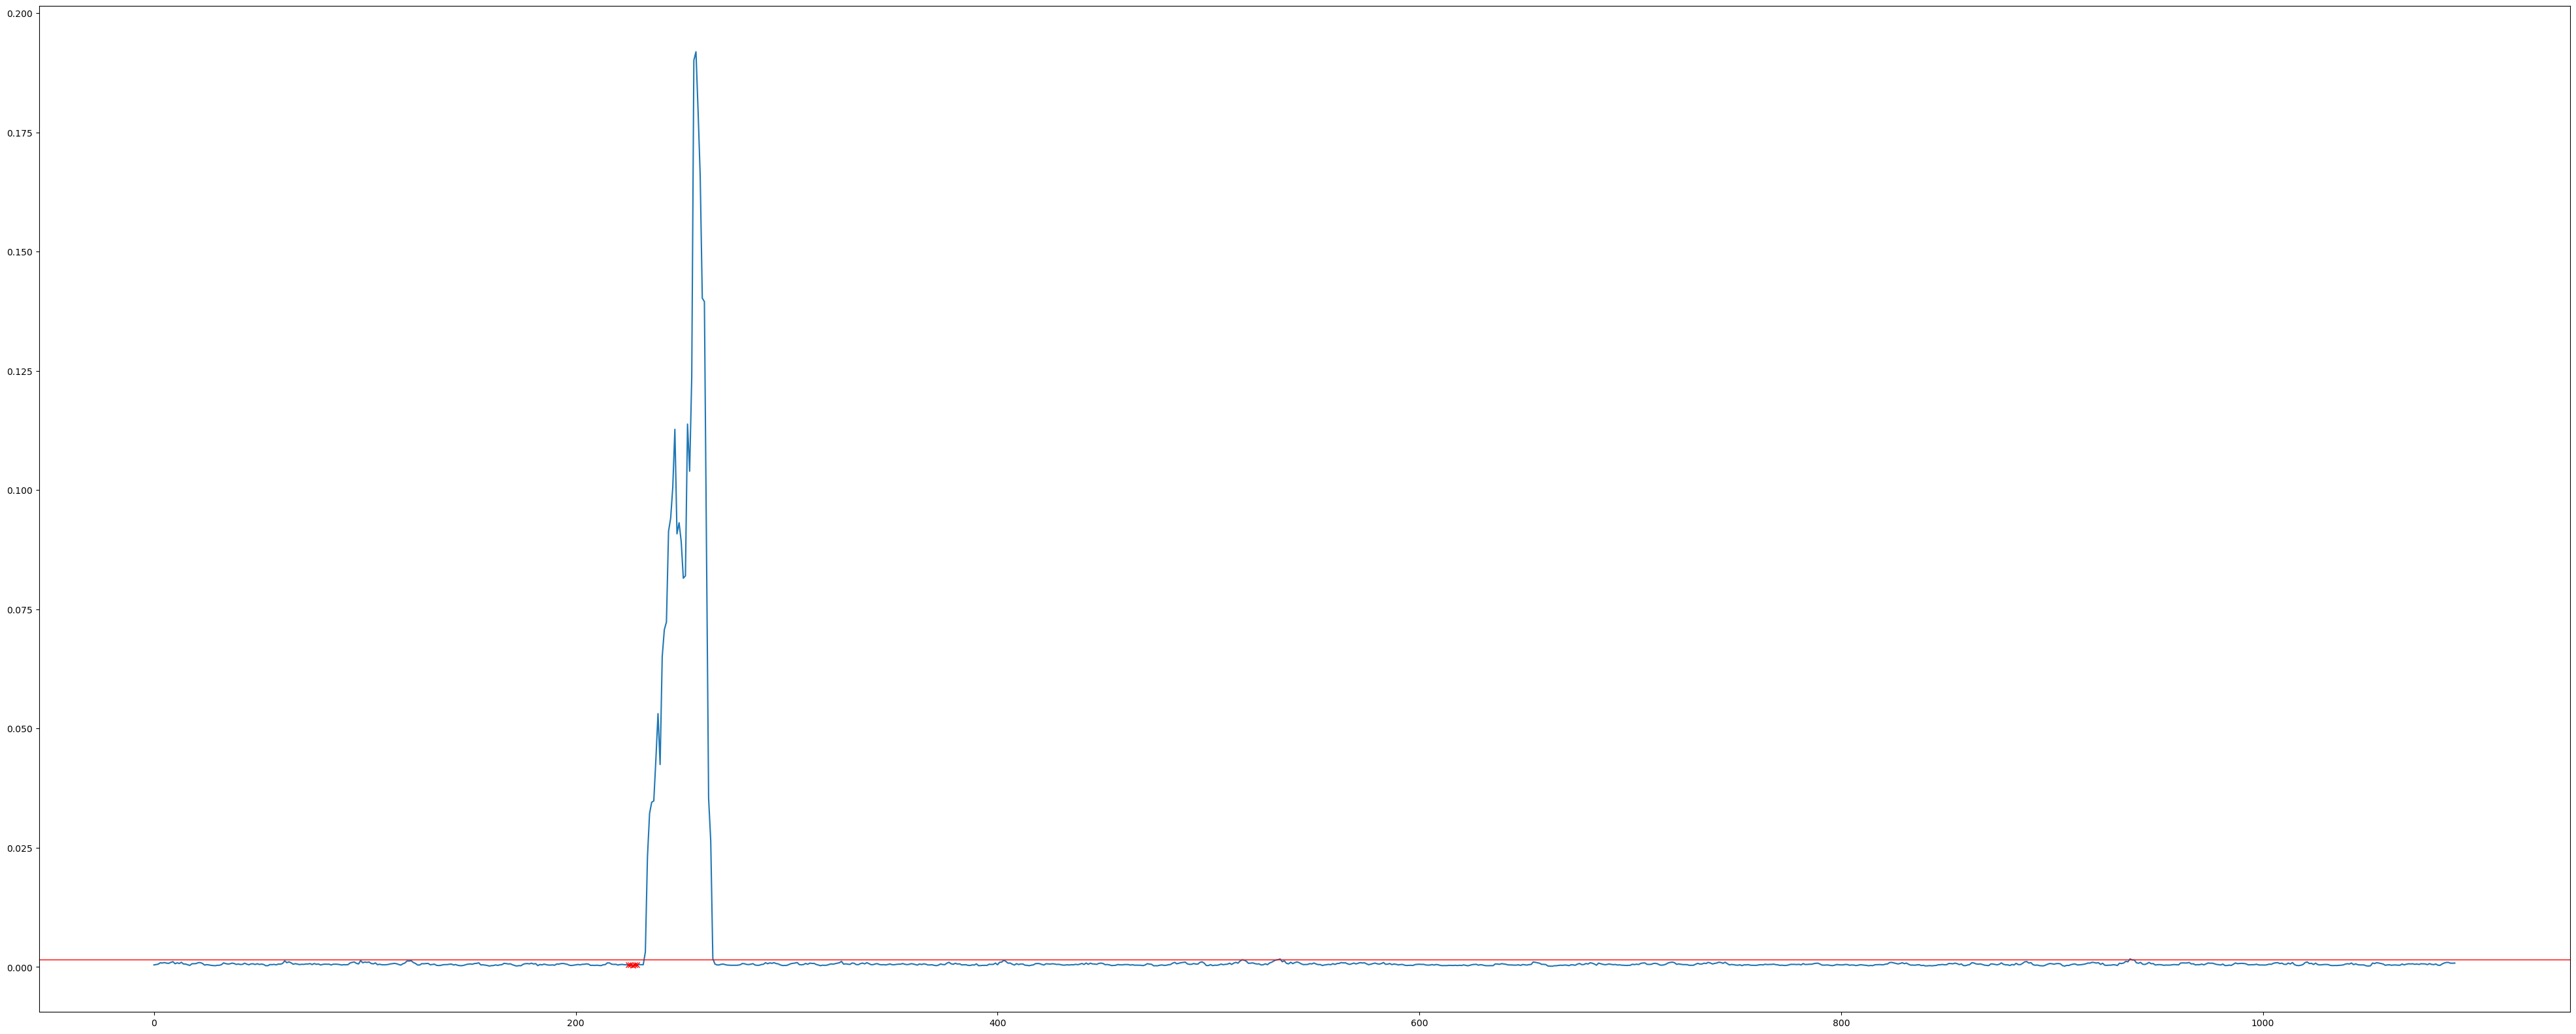

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
3


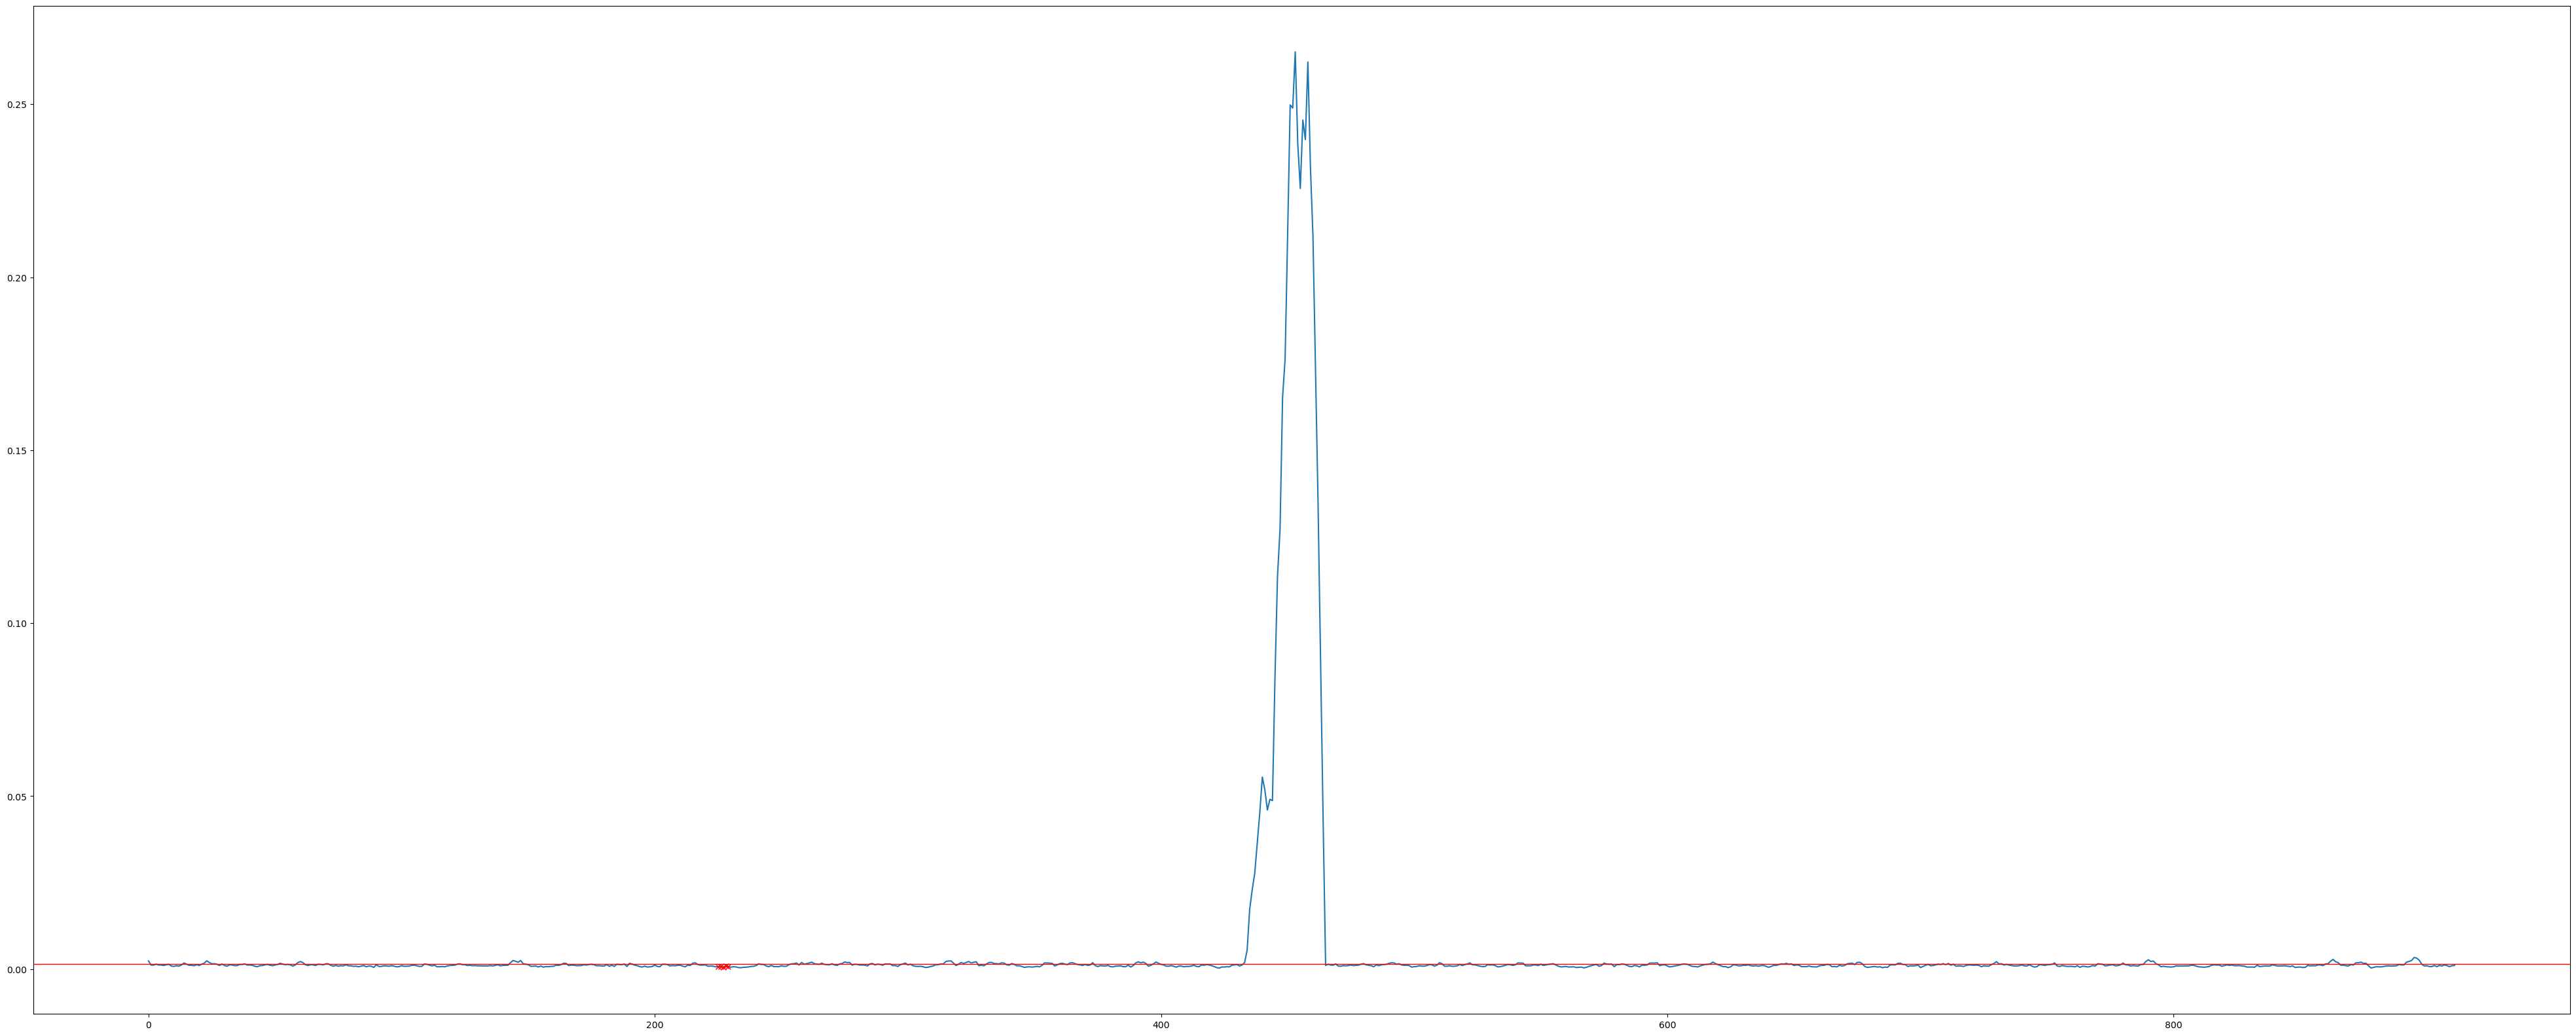

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
4


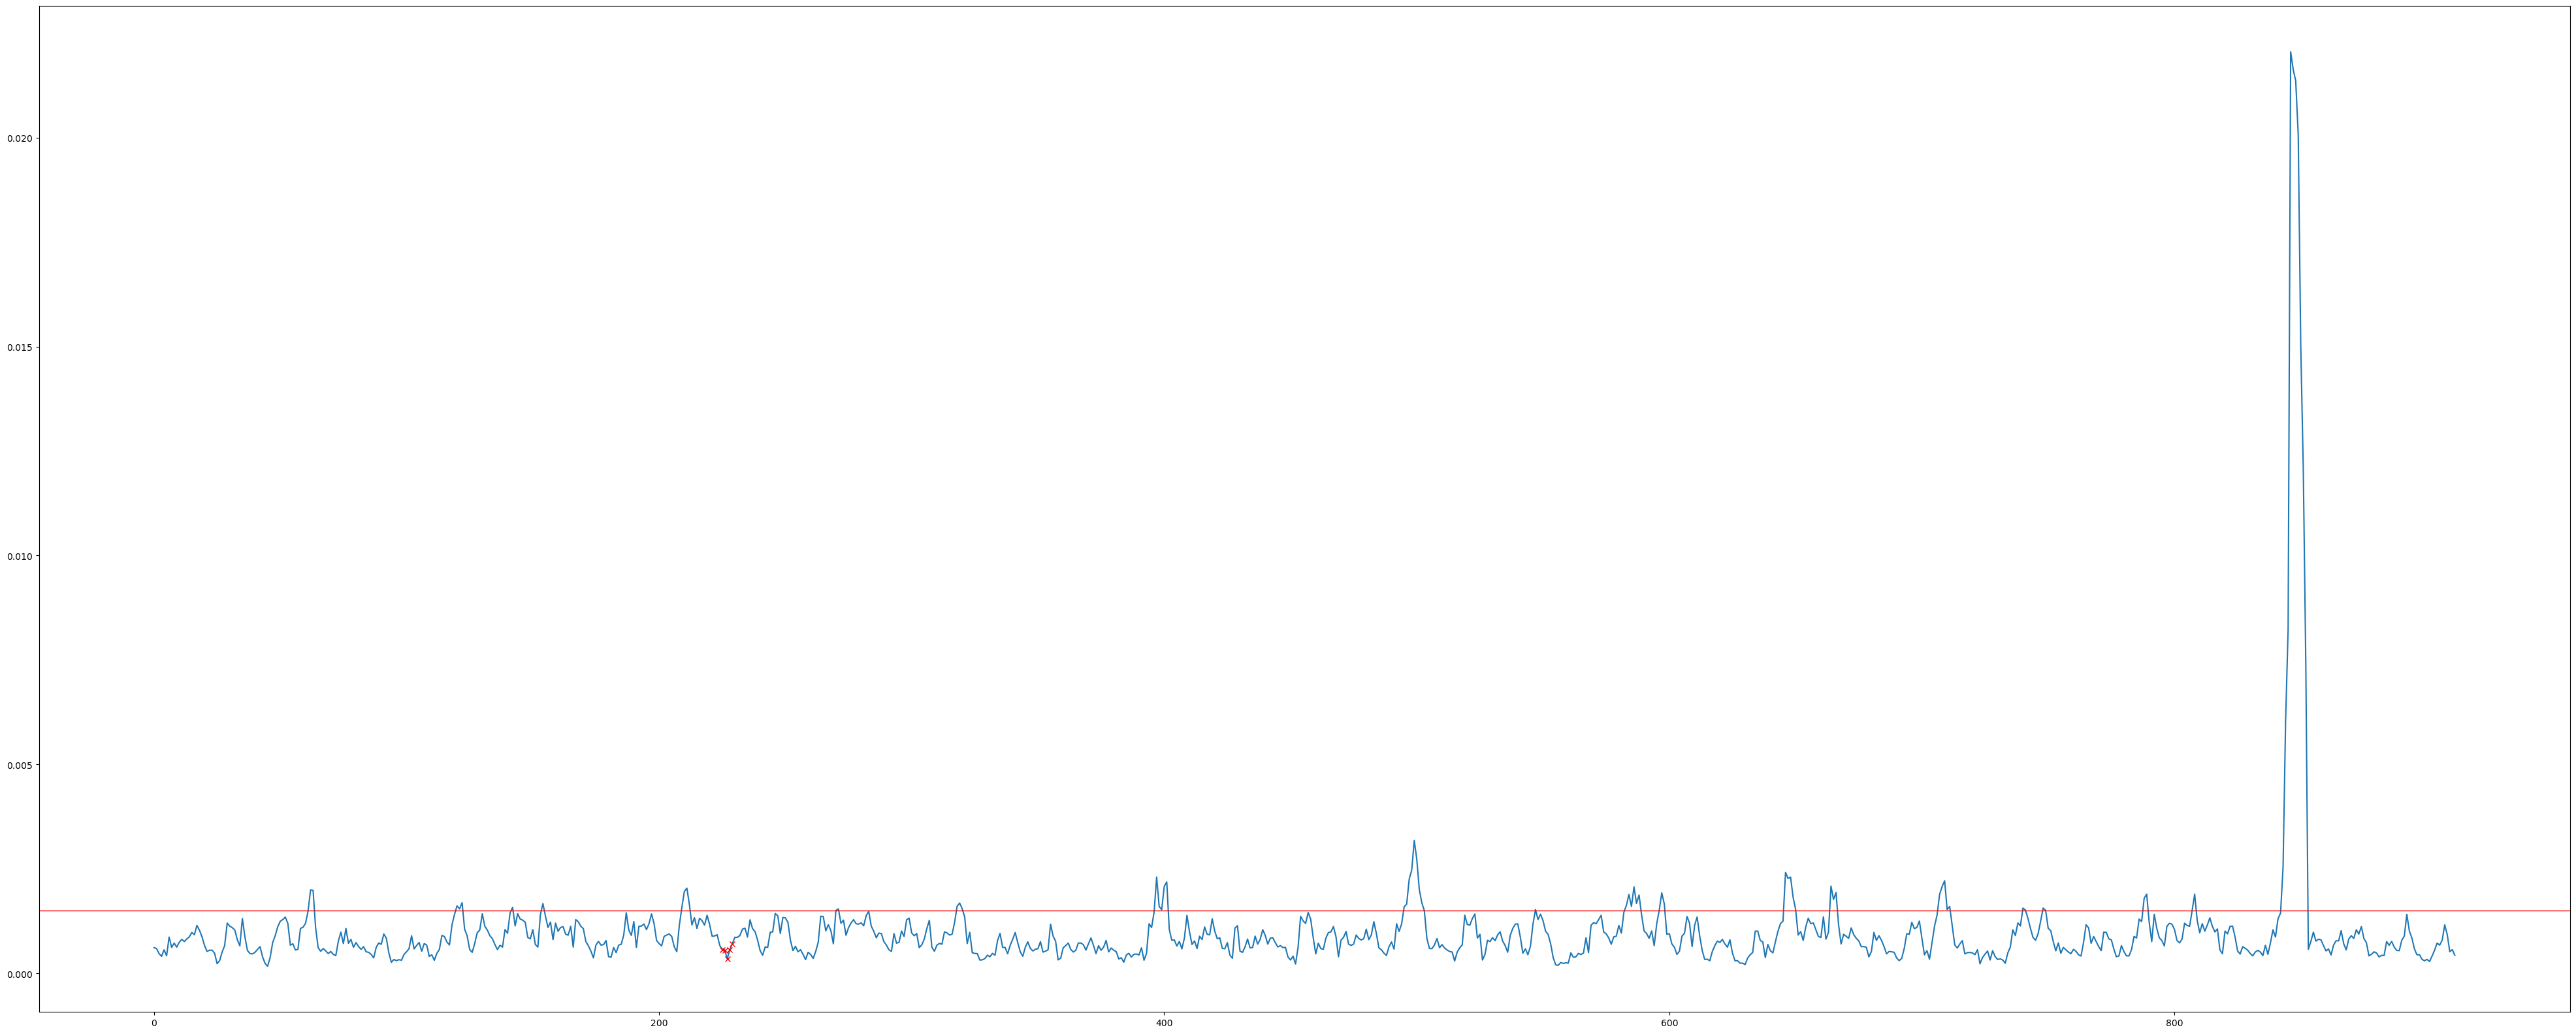

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(747, 7)
5


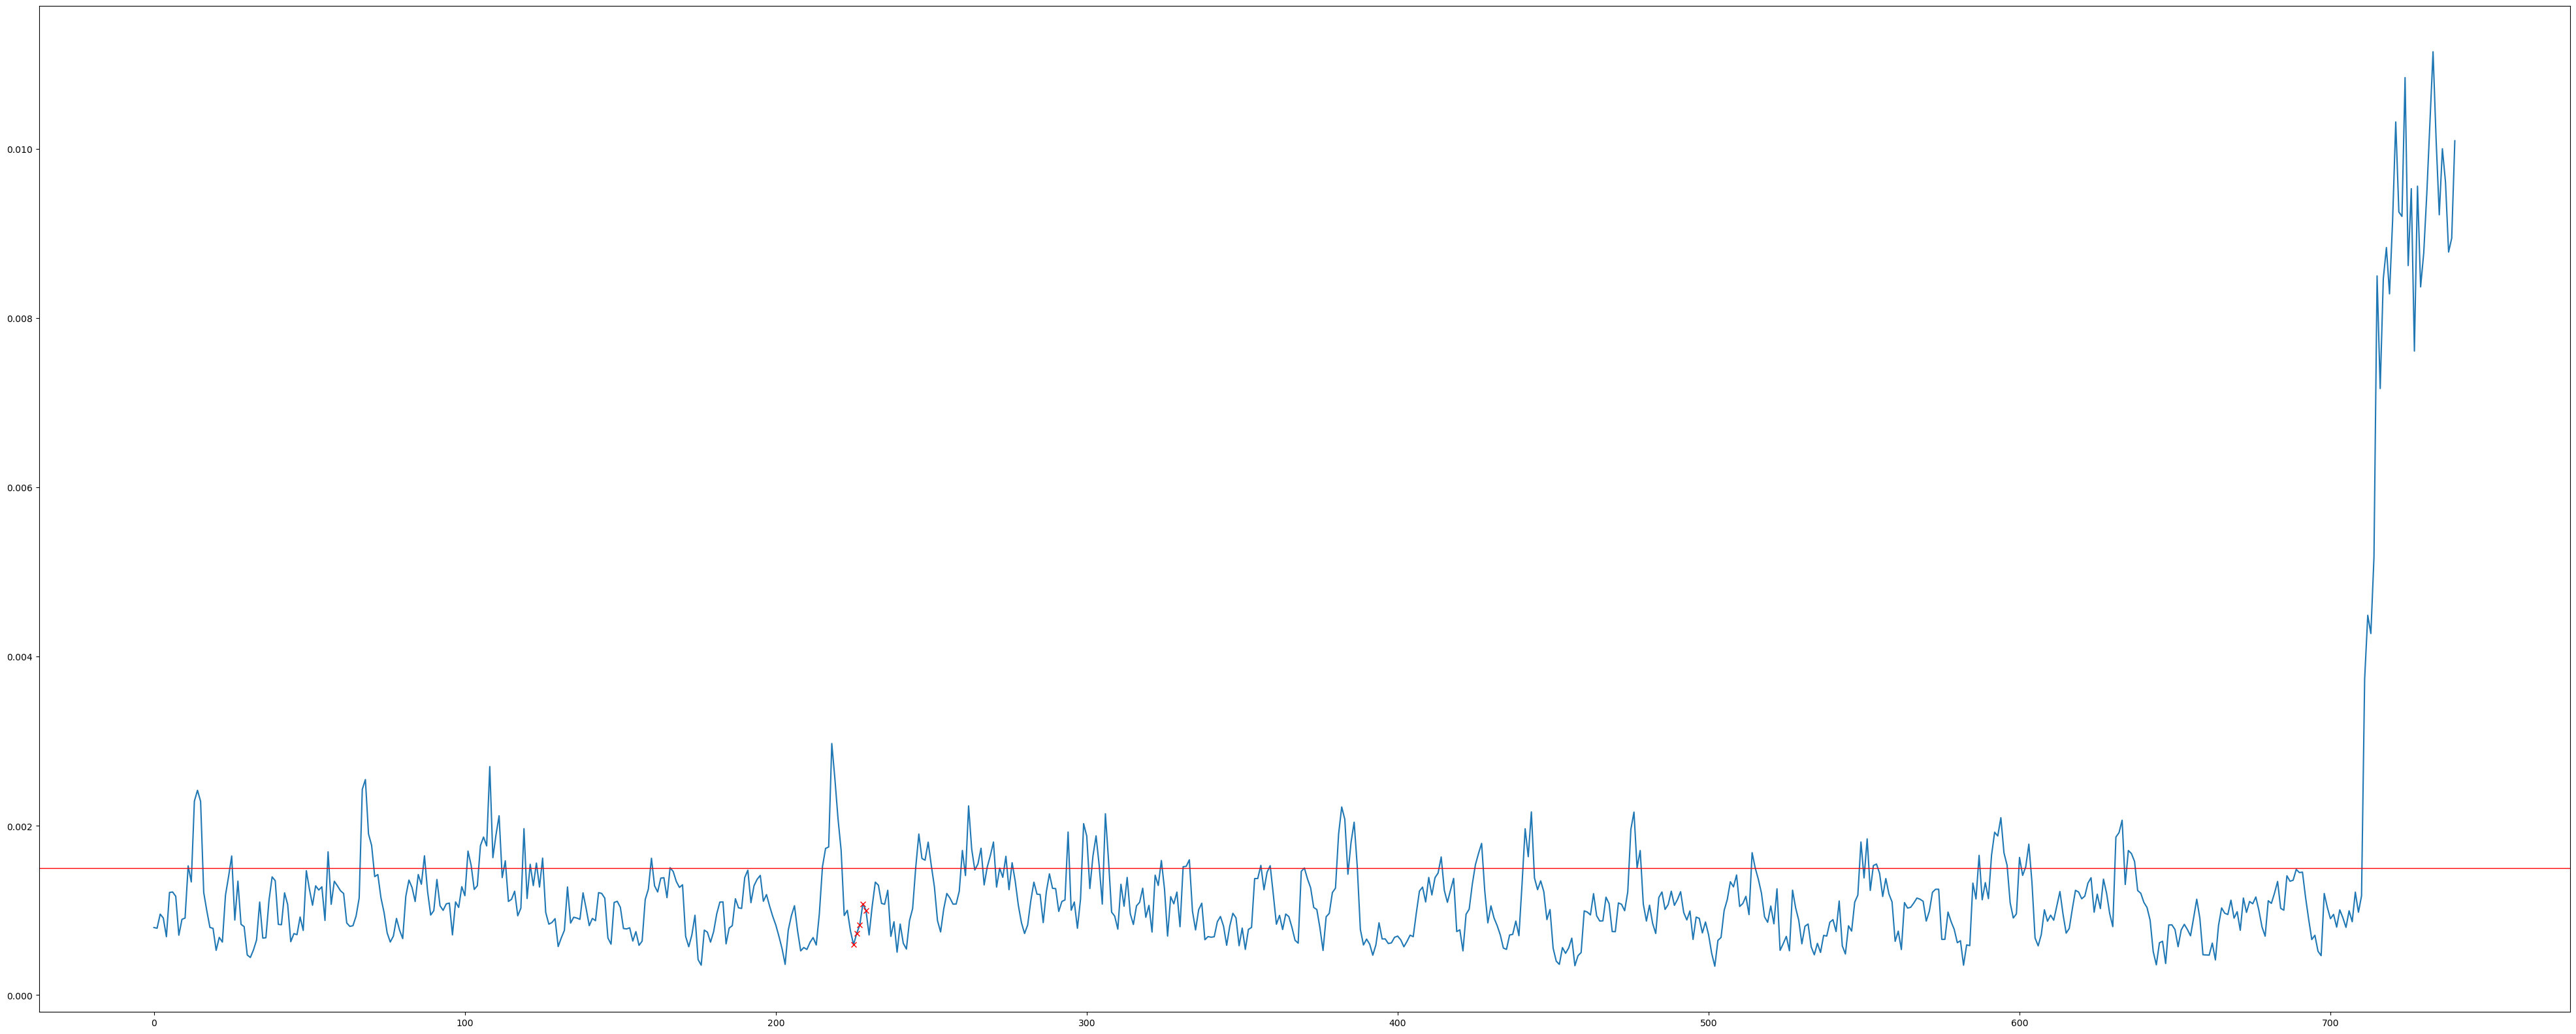

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(747, 7)
6


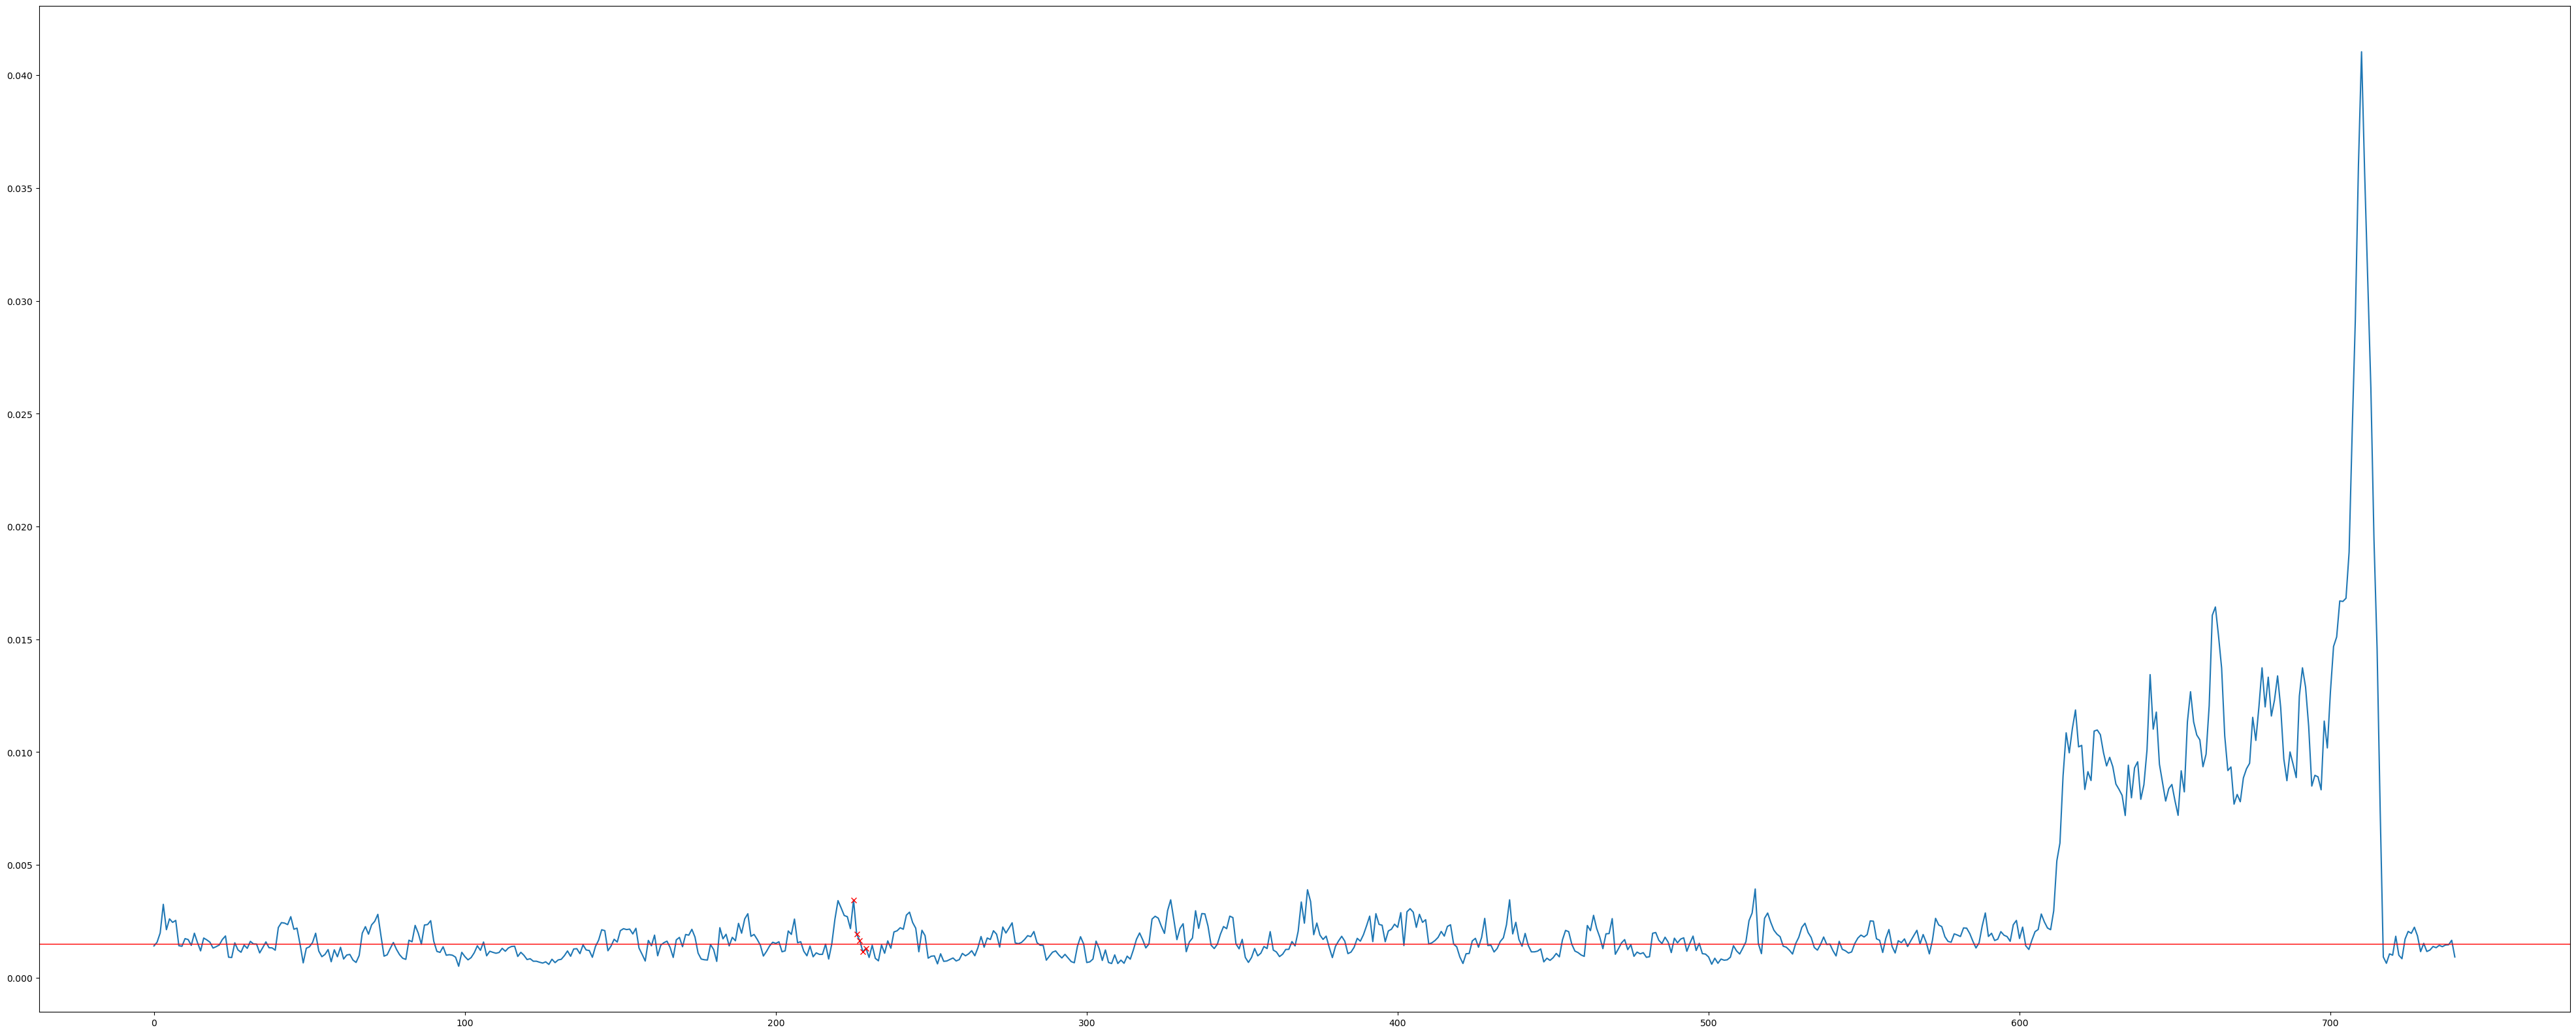

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(558, 7)
7


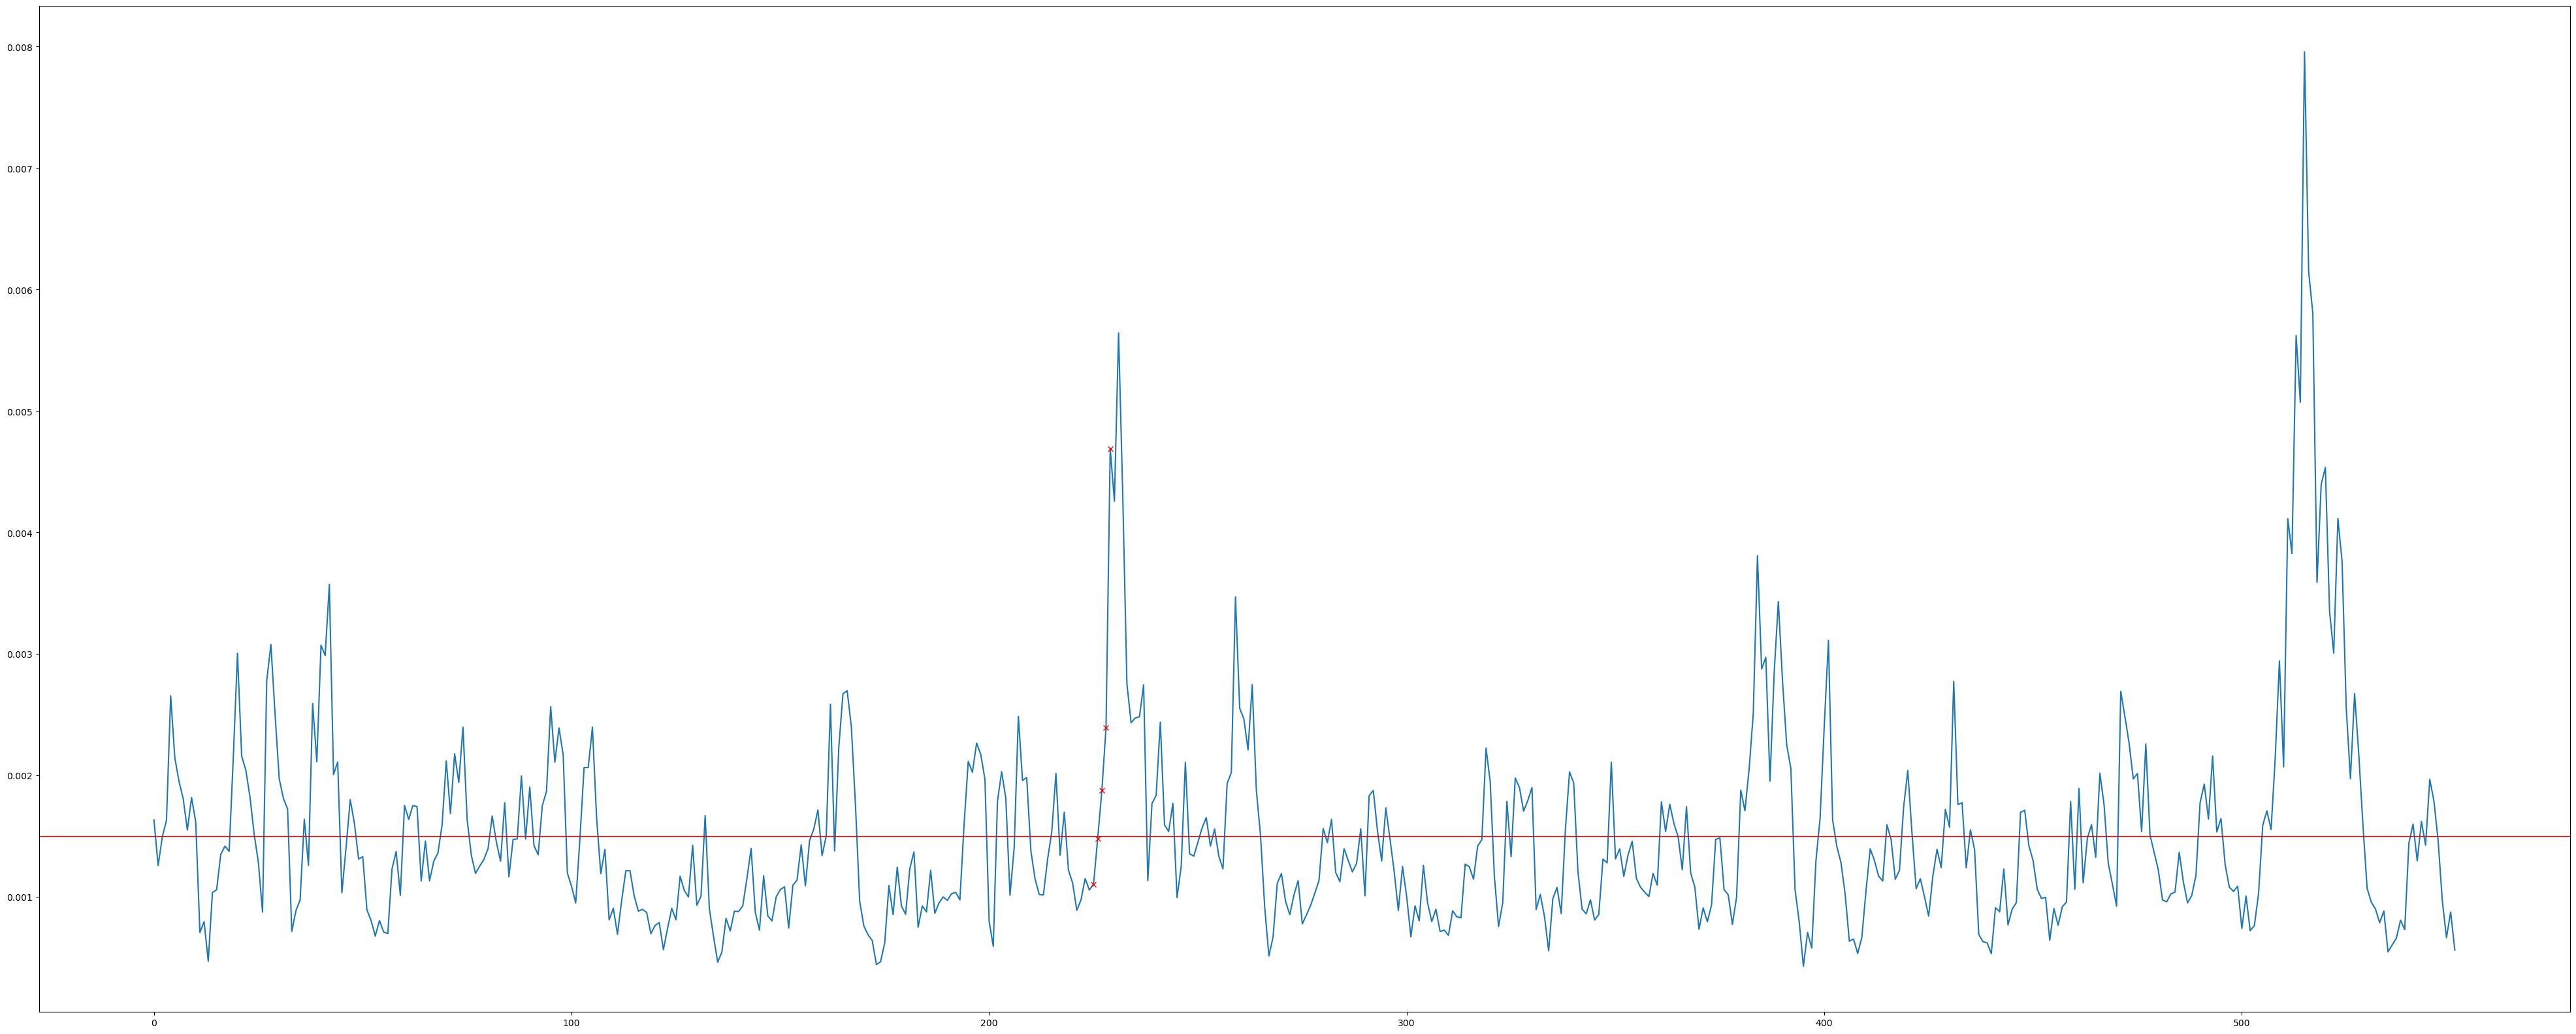

In [158]:
pred = []
#threshold = [0.003, 0.003, 0.003, 0.003, 0.001, 0.003, 0.003, 0.003]
threshold = [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015]
for i in range(8):
    pretrained_model = torch.load('./' + MODEL_NAME+str(i)+'.pth')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    summary(pretrained_model)

    test_type = test_df.loc[test_df['type']==i]
    test_data_drop = test_type.drop('type', axis=1)
    test_x = scaler_list[i].transform(test_data_drop)
    print(test_x.shape)

    test_dataset = MyDataset(making_model_input(test_x))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print(i)
    #print(threshold)
    test_loss = []
    criterion = nn.MSELoss().to(device)
    loss = []
    true = []
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x,_ = pretrained_model(x)
            loss.append(criterion(x,_x).cpu().detach())

    #mse_list = pd.Series(mse_list).ewm(alpha=0.5).mean(10)
    plt.figure(figsize=(50,20))
    plt.plot(loss)
    plt.plot(225, loss[225],'rx')
    plt.plot(226, loss[226],'rx')
    plt.plot(227, loss[227],'rx')
    plt.plot(228, loss[228],'rx')
    plt.plot(229, loss[229],'rx')
    #plt.ylim([0,1])
    plt.axhline(y=threshold[i], color='r', linewidth=1)
    #plt.axhline(y=mean_loss_list[i], color='b', linewidth=1)
    plt.show()
    '''mse_arr = torch.tensor(mse_list)
    tmp = torch.where(mse_arr > threshold[i], 1, 0).detach().tolist()
    flag = 0
    
    if len(tmp) > 10:
        for idx in range(len(tmp)-10):
            for k in range(2,10):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
                        
    elif len(tmp) <= 10 and len(tmp) > 2:
         for idx in range(len(tmp)):
            for k in range(2,len(tmp)-idx):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
    
    #warm up
    if len(tmp) > 2:
        for idx in range(2, len(mse_arr)):
            if tmp[idx]==1 and mse_arr[idx-1] > mse_arr[idx-2] and mse_arr[idx-1] > mean_loss_list[i]:
                tmp[idx-1]=1

    #plt.show()
    print(Counter(tmp)) 
    plt.figure(figsize=(50,20))
    plt.plot(tmp)
    plt.show()


    pred += tmp'''


#train start

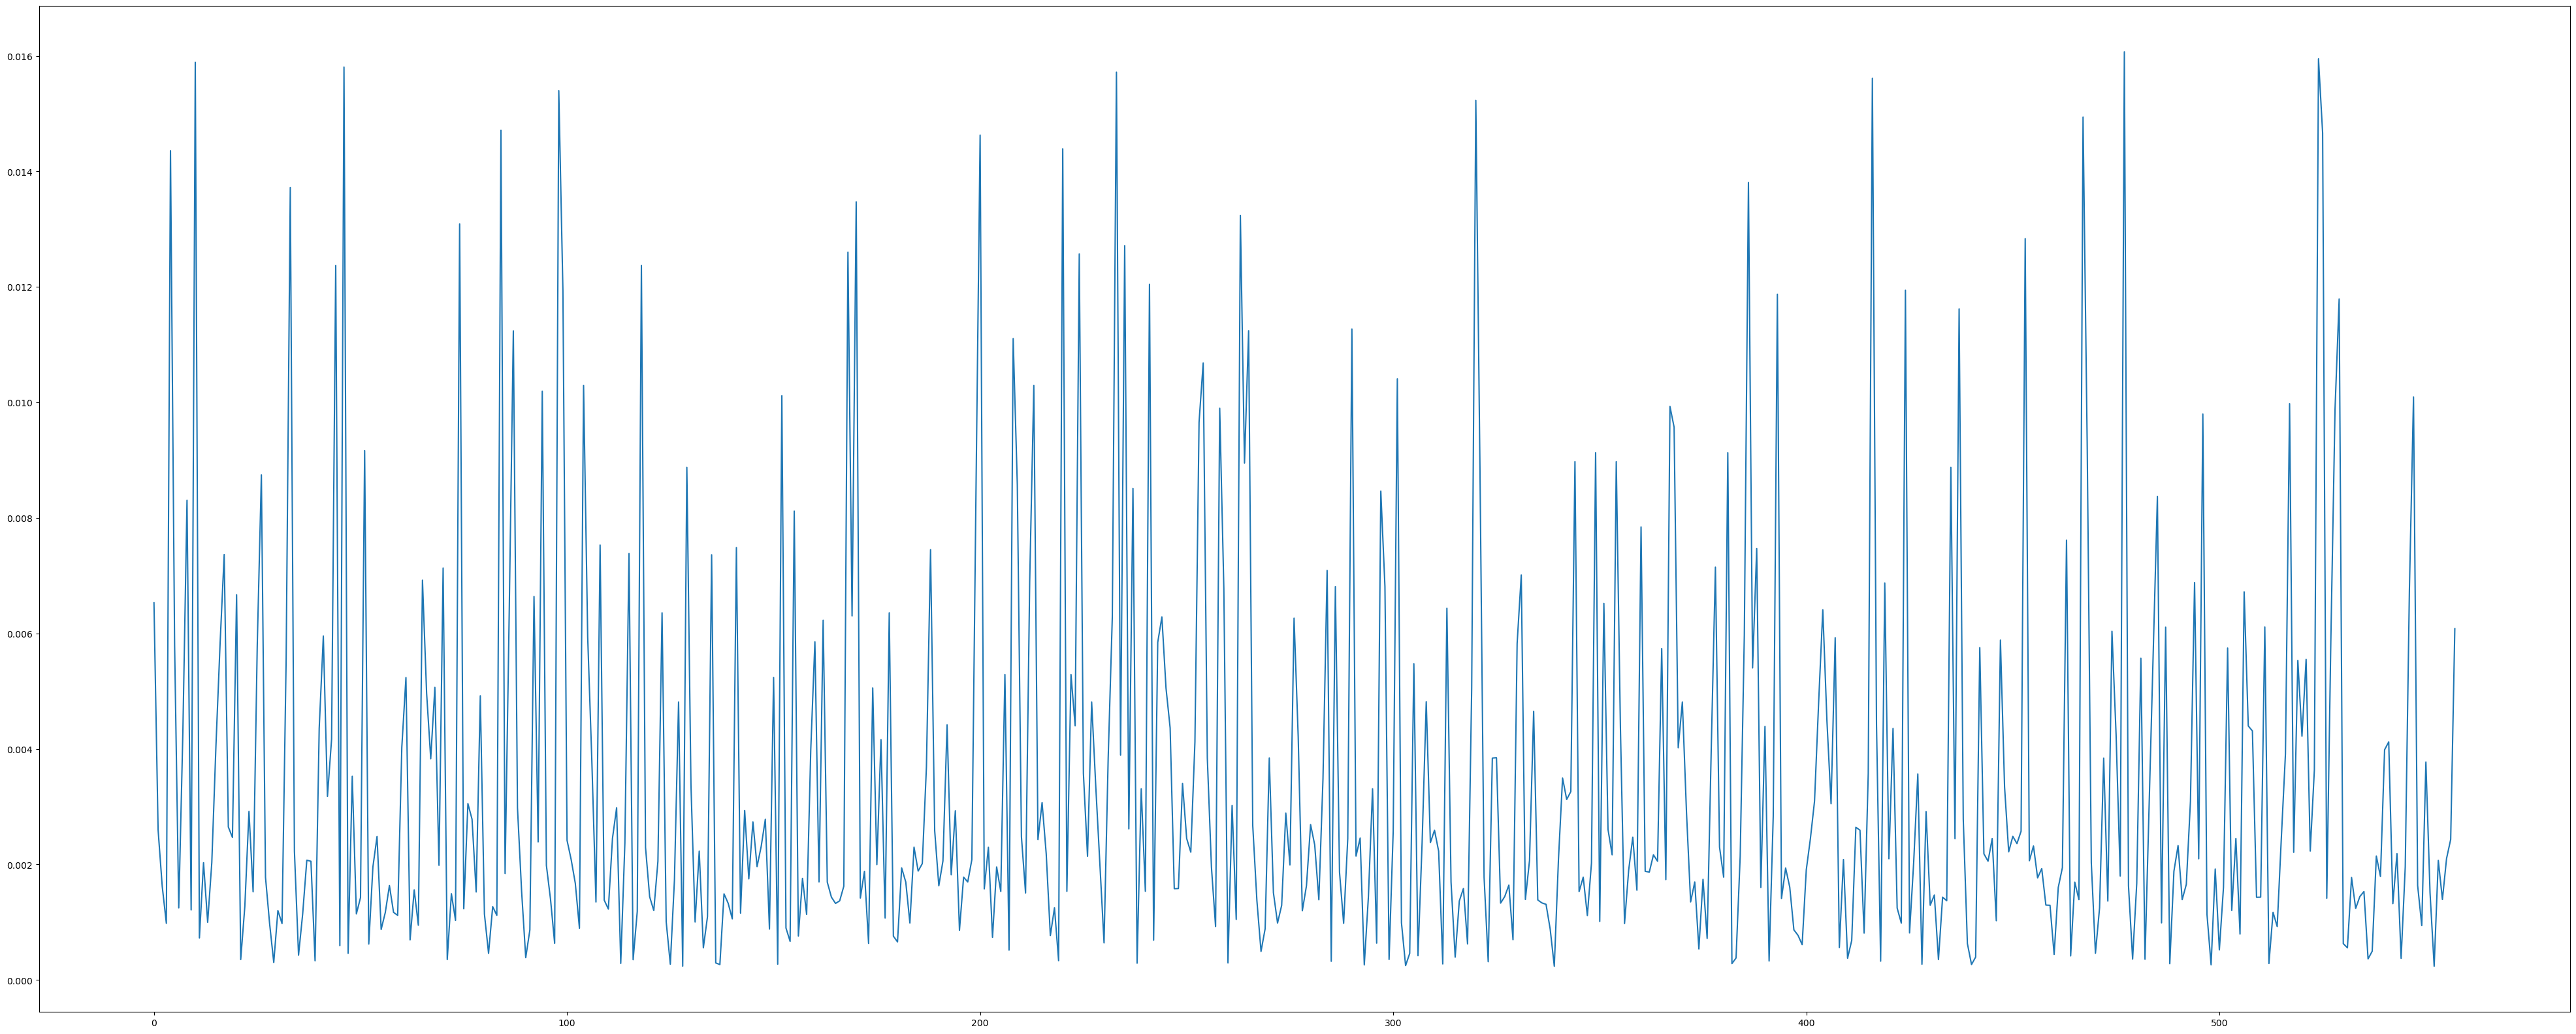

In [431]:
test_loss = []
mse_list = []
with torch.no_grad():
    for x in iter(test_loader):
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list.extend(mse)
plt.figure(figsize=(50,20))
plt.plot(mse_list)
plt.show()

for i in range(len(mse_list)):
    if mse_list[i]> 0.03:
        print(mse_list[i])